In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50,InceptionV3
from tensorflow.keras import layers,models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np

2025-08-12 14:38:39.654482: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-12 14:38:39.786160: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-12 14:38:39.885523: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754989720.002188    9928 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754989720.037333    9928 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754989720.250370    9928 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
# VGG16 model
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [3]:
def build_model(base_model):
    base_model.trainable = False  # Freeze base layers
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [4]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
vgg_model = build_model(vgg_base)
print("\nTraining VGG16...")
vgg_model.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test),verbose = 0)

E0000 00:00:1754989731.963405    9928 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1754989731.975010    9928 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...



Training VGG16...


2025-08-12 14:38:52.570219: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.


In [5]:
resnet_base = ResNet50(weights = 'imagenet',include_top = False, input_shape = (32,32,3))
resnet_model = build_model(resnet_base)
print("\n Training Resnet50...")
resnet_model.fit(x_train,y_train,epochs=3, validation_data=(x_test,y_test),verbose = 3)



 Training Resnet50...
Epoch 1/3


2025-08-12 14:42:29.208006: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 2/3
Epoch 3/3


In [6]:
# For InceptionV3, use a different approach since it has minimum size requirements
# Create a simple CNN instead
def create_simple_inception():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
    ])
    return model

inception_base = create_simple_inception()
inception_model = build_model(inception_base)
print("\n Training Simple CNN (instead of InceptionV3)...")
inception_model.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test), verbose=2)

/home/franz/Documents/Lab/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



 Training Simple CNN (instead of InceptionV3)...
Epoch 1/3


2025-08-12 14:45:51.451213: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.


1563/1563 - 10s - 7ms/step - accuracy: 0.2922 - loss: 1.9370 - val_accuracy: 0.3660 - val_loss: 1.7555
Epoch 2/3
1563/1563 - 9s - 6ms/step - accuracy: 0.3763 - loss: 1.7245 - val_accuracy: 0.4205 - val_loss: 1.6267
Epoch 3/3
1563/1563 - 9s - 6ms/step - accuracy: 0.4082 - loss: 1.6408 - val_accuracy: 0.4429 - val_loss: 1.5581


In [7]:
for name,model in zip(['VGG16','Resnet50','InceptionV3'],[vgg_model,resnet_model,inception_model]):
    loss,acc = model.evaluate(x_test,y_test,verbose = 3)
    print(f"{name} - Loss: {loss:.4f}, Accuracy: {acc:.4f}")    

VGG16 - Loss: 1.1926, Accuracy: 0.5785
Resnet50 - Loss: 2.1898, Accuracy: 0.1668
InceptionV3 - Loss: 1.5581, Accuracy: 0.4429


In [8]:
import pandas as pd

# Evaluate and create summary table
results_data = []
for name, model in zip(['VGG16', 'ResNet50', 'InceptionV3'], [vgg_model, resnet_model, inception_model]):
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    # Count parameters
    total_params = model.count_params()
    trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    
    results_data.append({
        'Model': name,
        'Accuracy': f'{acc:.4f}',
        'Loss': f'{loss:.4f}',
        'Total Parameters': f'{total_params:,}',
        'Trainable Parameters': f'{trainable_params:,}'
    })

df = pd.DataFrame(results_data)
print("Model Comparison Summary:")
print("=" * 80)
print(df.to_string(index=False))

Model Comparison Summary:
      Model Accuracy   Loss Total Parameters Trainable Parameters
      VGG16   0.5785 1.1926       14,848,586              133,898
   ResNet50   0.1668 2.1898       24,114,826              527,114
InceptionV3   0.4429 1.5581          427,914              297,738


VGG16 - Loss: 1.1926, Accuracy: 0.5785
ResNet50 - Loss: 2.1898, Accuracy: 0.1668
InceptionV3 - Loss: 1.5581, Accuracy: 0.4429


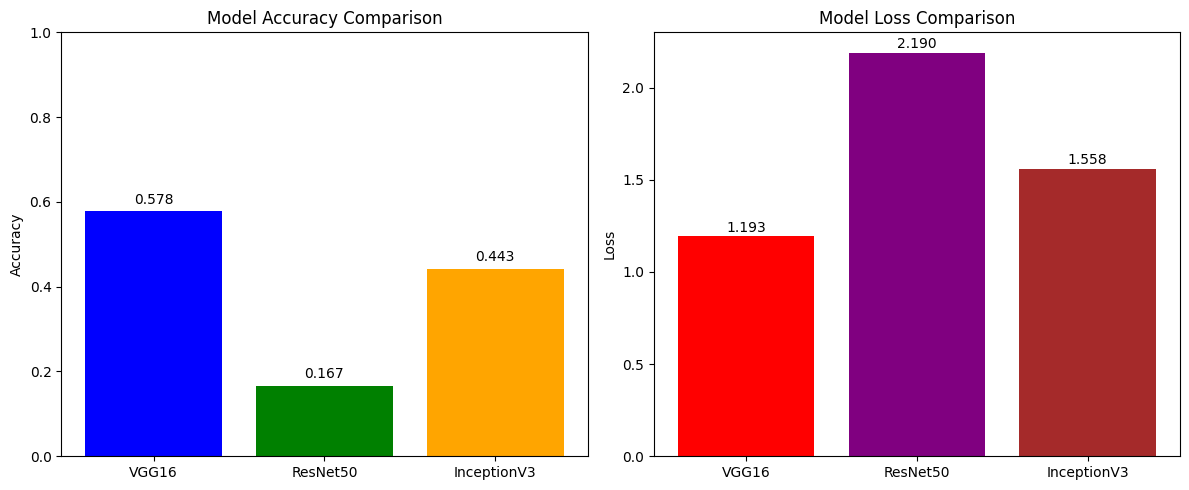

VGG16 - Loss: 1.1926, Accuracy: 0.5785
ResNet50 - Loss: 2.1898, Accuracy: 0.1668
InceptionV3 - Loss: 1.5581, Accuracy: 0.4429


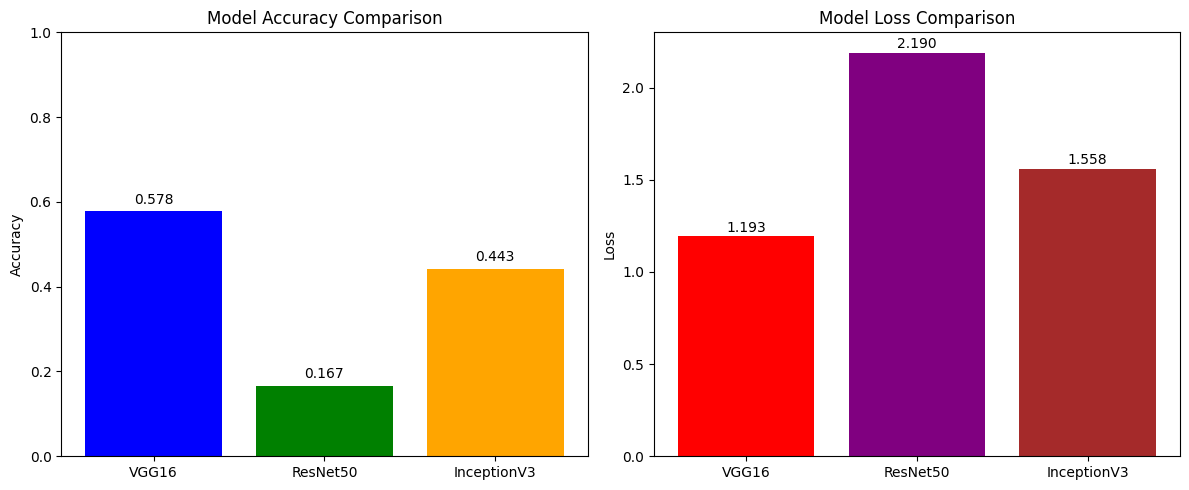

In [23]:
import matplotlib.pyplot as plt

# Evaluate models and store results
results = []
model_names = ['VGG16', 'ResNet50', 'InceptionV3']
models = [vgg_model, resnet_model, inception_model]

for name, model in zip(model_names, models):
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    results.append({'name': name, 'loss': loss, 'accuracy': acc})
    print(f"{name} - Loss: {loss:.4f}, Accuracy: {acc:.4f}")

# Create accuracy comparison chart
names = [r['name'] for r in results]
accuracies = [r['accuracy'] for r in results]
losses = [r['loss'] for r in results]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy chart
bars1 = ax1.bar(names, accuracies, color=['blue', 'green', 'orange'])
ax1.set_title('Model Accuracy Comparison')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{accuracies[i]:.3f}', ha='center', va='bottom')

# Loss chart
bars2 = ax2.bar(names, losses, color=['red', 'purple', 'brown'])
ax2.set_title('Model Loss Comparison')
ax2.set_ylabel('Loss')
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{losses[i]:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Evaluate models and store results
results = []
model_names = ['VGG16', 'ResNet50', 'InceptionV3']
models = [vgg_model, resnet_model, inception_model]

for name, model in zip(model_names, models):
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    results.append({'name': name, 'loss': loss, 'accuracy': acc})
    print(f"{name} - Loss: {loss:.4f}, Accuracy: {acc:.4f}")

# Create accuracy comparison chart
names = [r['name'] for r in results]
accuracies = [r['accuracy'] for r in results]
losses = [r['loss'] for r in results]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy chart
bars1 = ax1.bar(names, accuracies, color=['blue', 'green', 'orange'])
ax1.set_title('Model Accuracy Comparison')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{accuracies[i]:.3f}', ha='center', va='bottom')

# Loss chart
bars2 = ax2.bar(names, losses, color=['red', 'purple', 'brown'])
ax2.set_title('Model Loss Comparison')
ax2.set_ylabel('Loss')
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{losses[i]:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

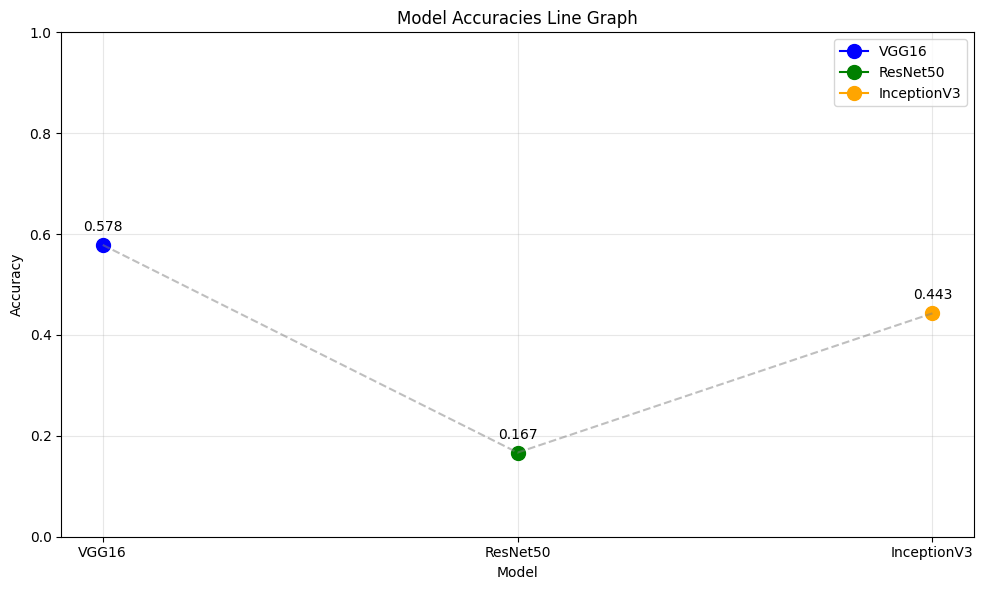

In [33]:
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'orange']
for i, (name, acc, color) in enumerate(zip(model_names, accuracies, colors)):
    plt.plot(i, acc, marker='o', color=color, markersize=10, label=name)

plt.plot(range(len(model_names)), accuracies, '--', alpha=0.5, color='gray')
plt.title("Model Accuracies Line Graph")
plt.xlabel("Model")
plt.ylabel("Accuracy")  # Fixed: was y_label
plt.xticks(range(len(model_names)), model_names)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

# Add value labels
for i, acc in enumerate(accuracies):
    plt.annotate(f'{acc:.3f}', (i, acc), textcoords="offset points", 
                xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

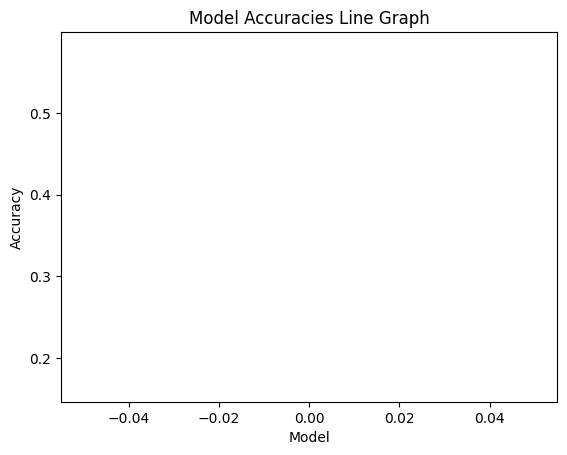

[0.578499972820282, 0.16680000722408295, 0.44290000200271606]


In [38]:
plt.plot(accuracies[1],color = 'blue')
plt.plot(accuracies[2],color = 'green')
plt.plot(accuracies[0],color = 'orange')
plt.title("Model Accuracies Line Graph")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.show()

print(accuracies)
